In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate

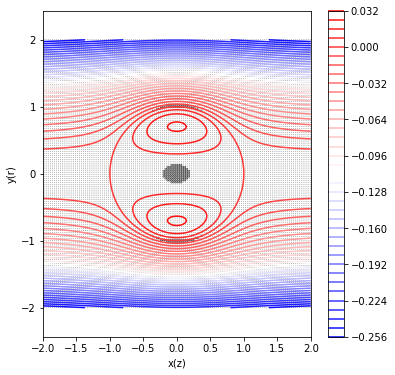

In [255]:
# set up grids
Ny = 140
Nx = 140
x = np.linspace(-2,2,Ny)
y = np.linspace(-2,2,Nx)
if np.any(y == 0):
    raise ValueError("Zero found in the y(r) coordinates")
X, Y = np.meshgrid(x, y)
rad_dist = np.sqrt(X**2 + Y**2)

# define parameters
alpha = 1
a = 1

# define streamfunctions
psi = np.empty_like(rad_dist)
psi[rad_dist <= a] = alpha * (Y[rad_dist <= a]**2) * (a**2 - rad_dist[rad_dist <= a]**2) / 10
psi[rad_dist > a] = -alpha * (a**2) * (Y[rad_dist > a]**2) * (1 - a**3 / rad_dist[rad_dist > a]**3) / 15
# fig, ax = plt.subplots(layout='constrained')
# CS = ax.contour(X, Y, psi, 80, cmap='bwr')
# cbar = fig.colorbar(CS)

# define velocity fields
Uf = np.empty_like(psi)
Uf[rad_dist <= a] = alpha * (a**2 - rad_dist[rad_dist <= a]**2 - Y[rad_dist <= a]**2) / 5
Uf[rad_dist > a] = (-alpha*(a**5)/15) * (2/(a**3) + (rad_dist[rad_dist > a]**2 - 2*(X[rad_dist > a]**2))
                                         /(rad_dist[rad_dist > a]**5))



Vf = np.empty_like(psi)
Vf[rad_dist <= a] = alpha * X[rad_dist <= a] * Y[rad_dist <= a] / 5
Vf[rad_dist > a] = alpha* (a**5) * Y[rad_dist > a] * X[rad_dist > a] / ( 5*(rad_dist[rad_dist > a] ** 5))


# Create a quiver plot to visualize the velocity field
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, Uf, Vf, scale=80, color='black',headlength=1)
CS = plt.contour(X, Y, psi, levels=40, cmap='bwr')
cbar = plt.colorbar(CS)
plt.xlabel('x(z)')
plt.ylabel('y(r)')
plt.axis('equal')
plt.show()


In [271]:
#### compute particle trajectories
t0 = 0
tf = 60

# Solve the IVP RK4 -- for FLUID particles
def solve_ivp_passive(r0, t0=t0, tf=tf):

      """
      argument r0 should be a LIST : [x0, y0]
      """

      # define the IVP to solve -- for FLUID particles
      t_span = np.linspace(t0,tf,500)

      def passive_tracer_traj(t, r):
            X, Y = r
            dist = np.sqrt(X**2 + Y**2)
            if dist <= a:
                  fx = alpha * (a**2 - dist**2 - Y**2) / 5
                  fy = alpha * X * Y / 5
            else :
                  fx = (-alpha*(a**5)/15) * (2/(a**3) + (Y**2 - 2*(X**2))/(dist**5))
                  fy = alpha* a**5 * Y * X/ ( 5*(dist ** 5))
            return [-fx, -fy]

      passive_sol = sp.integrate.solve_ivp(passive_tracer_traj, [t0,tf], r0, t_eval=t_span, vectorized=True)
      xt, yt = passive_sol.y
      return xt, yt


In [272]:
### compute the particle flow map in the whole domain

# create a flattened array of grid points, first index is x
grid_coords = np.column_stack((X.ravel(), Y.ravel()))
final_coords = np.empty_like(grid_coords, dtype=object)

# loop through all lagrangian grid points to find final positions
for i, point in enumerate(grid_coords):
    r0 = [grid_coords[i, 0], grid_coords[i, 1]]
    rt = solve_ivp_passive(r0, t0, tf)
    final_coords[i,:] = [rt[k][-1] for k in [0,1]]

# ## using multiprocessing
# '''
# output [res], a list with len = Nx*Ny, 
# each list element is an array of t_span for one particle
# '''
# from multiprocessing import Pool

# n_proc = 12
# with Pool(n_proc) as pool:
#     args = list( grid_coords )
#     res = pool.map( solve_ivp_passive, args )

# final_coords = np.array([(point[0][-1], point[1][-1]) for point in res], dtype=float)



# flow map, each row has 4 entries [x0, y0, xf, yf]
flow_map = np.column_stack((grid_coords, final_coords))
# np.save(f'hills_tf{tf}.npy', flow_map)



In [273]:

# this is a 3D array and the first two indicies are the particle "Name" (defined by its initial position)
flow_map_arr = np.array([tuple(row) for row in flow_map]).reshape((Ny, Nx, 4))
X0 = flow_map_arr[:,:,0]
Y0 = flow_map_arr[:,:,1]
Xf = flow_map_arr[:,:,2]
Yf = flow_map_arr[:,:,3]

In [274]:
def compute_ftle(xi, yj, t0, tf):

    D = np.zeros((2,2))   # 2D deformation gradient matrix
    D[0,0] = (Xf[yj, xi+1] - Xf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[0,1] = (Xf[yj+1, xi] - Xf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])
    D[1,0] = (Yf[yj, xi+1] - Yf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[1,1] = (Yf[yj+1, xi] - Yf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])

    # CGDtensor = D.T @ D # symmetric square real matrix must have orthogonal eigenvectors,  the SV's are the absolute values of the eigenvalues
    # _, SV, _ = np.linalg.svd(CGDtensor, hermitian=True)

    _, SV, _ = np.linalg.svd(D)

    if SV[0] < 1:
        SV = np.ones_like(SV)
    else:
        SV[1] = 1/SV[0]

    ftle = np.log(SV[0]) / np.abs(tf-t0)
    
    return ftle

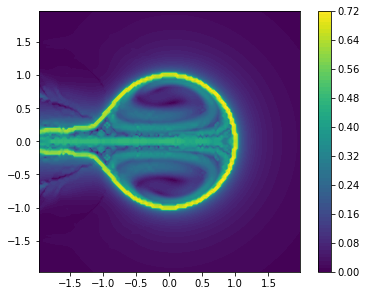

In [275]:
FTLE_field = np.empty((Ny-2, Nx-2))

for xi in range(Nx-2) :
    for yj in range(Ny-2) :
        FTLE_field[yj, xi] = compute_ftle((xi+1), (yj+1), t0=0, tf=7.5)

fig, ax = plt.subplots(layout='constrained')
CS = ax.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], FTLE_field, 80)
ax.set_aspect('equal')
cbar = fig.colorbar(CS)

Plotting the repelling LCS (stable manifold of rear stagnant point)

(-1.2446043165467626,
 1.1294964028776981,
 -1.1237410071942444,
 1.1237410071942449)

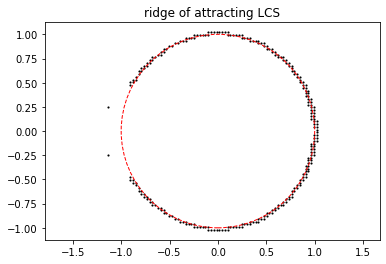

In [276]:
rLCS_x = X[1:-1, 1:-1][np.where(FTLE_field >= 0.9*FTLE_field.max())]
rLCS_y = Y[1:-1, 1:-1][np.where(FTLE_field >= 0.9*FTLE_field.max())]

plt.scatter(rLCS_x, rLCS_y, s=5, c='black', marker='.')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.axis('equal')
plt.title('ridge of attracting LCS')
# Define circle parameters
circle_radius = a
circle_center = (0, 0)

# Create a circle and add it to the plot
circle = plt.Circle(circle_center, circle_radius, edgecolor='r', facecolor='none', linestyle='dashed')
plt.gca().add_patch(circle)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.axis('equal')

Collect all the points inside the rLCS structure

In [277]:
rLCS_idx = np.array(np.where(FTLE_field >= 0.9*FTLE_field.max())) + 1

point_dict = {}
for X_LCS in range(rLCS_idx.shape[1]):
    this_x = rLCS_idx[1, X_LCS]
    this_y = Y[rLCS_idx[0, X_LCS], 0]
    if this_x not in point_dict:
        point_dict[this_x] = abs(this_y)
    else:
        if abs(this_y) > point_dict[this_x]: 
            point_dict[this_x] = abs(this_y)

def r_u_in_rLCS(n_grid_coord):
    idx = np.unravel_index(n_grid_coord, X.shape)
    if idx[1] in point_dict:
        this_y = Y[idx[0], 0]
        if abs(this_y) < point_dict[idx[1]]:
            return True
    
    return False

in_rLCS = np.empty((len(grid_coords,)))

for point in range(len(grid_coords)):
    in_rLCS[point] = r_u_in_rLCS(point)




(-1.2446043165467626,
 1.1294964028776981,
 -1.1223021582733812,
 1.0935251798561152)

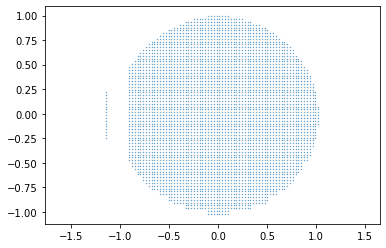

In [278]:
what = grid_coords[in_rLCS == 1]
plt.scatter(what[:,0], what[:, 1], s=0.1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.axis('equal')

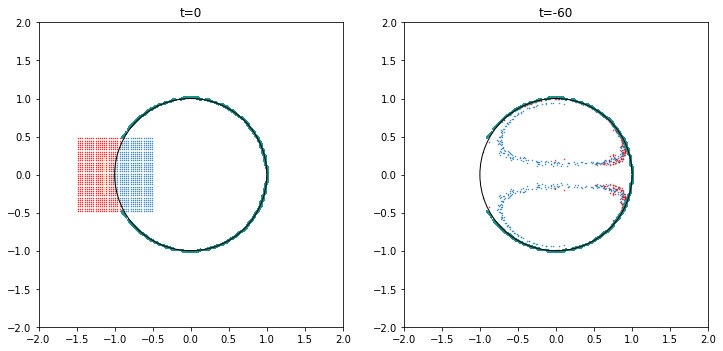

In [279]:
grid_dist = np.sqrt(grid_coords[:,0]**2 + grid_coords[:,1]**2)

cond_in_ring = (grid_dist < a)  & (grid_coords[:,0]<-0.5) & (grid_coords[:,1]<0.5) \
                      & (grid_coords[:,1]>-0.5) & (grid_coords[:,0]>-1.5)
inside_ring = grid_coords[cond_in_ring]
inside_ring_after = final_coords[cond_in_ring] 

cond_in_LCS = (grid_dist > a)  & (grid_coords[:,0]<-0.5) & (grid_coords[:,1]<0.5) \
                      & (grid_coords[:,1]>-0.5) & (grid_coords[:,0]>-1.5) & (in_rLCS==1)
inside_LCS = grid_coords[cond_in_LCS]
inside_LCS_after = final_coords[cond_in_LCS] 

cond_out_LCS = (grid_dist > a)  & (grid_coords[:,0]<-0.5) & (grid_coords[:,1]<0.5) \
                      & (grid_coords[:,1]>-0.5) & (grid_coords[:,0]>-1.5) & (in_rLCS==0)
outside_LCS = grid_coords[cond_out_LCS]
outside_LCS_after = final_coords[cond_out_LCS] 


fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].scatter(inside_ring[:,0],inside_ring[:,1], s=0.2)
ax[0].scatter(inside_LCS[:, 0], inside_LCS[:,1], s=0.1, c='y')
ax[0].scatter(outside_LCS[:,0], outside_LCS[:,1], s=0.2, c='r')
ax[0].contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], FTLE_field, levels=[0.9*np.max(FTLE_field), np.max(FTLE_field)])
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-2, 2])
ax[0].set_aspect('equal')
ax[0].set_title('t=0')

ax[1].scatter(inside_ring_after[:,0],inside_ring_after[:,1], s=0.2)
ax[1].scatter(inside_LCS_after[:, 0], inside_LCS_after[:,1], s=0.2, c='y')
ax[1].scatter(outside_LCS_after[:,0], outside_LCS_after[:,1], s=0.2, c='r')
ax[1].contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], FTLE_field, levels=[0.9*np.max(FTLE_field), np.max(FTLE_field)])
ax[1].set_xlim([-2,2])
ax[1].set_ylim([-2, 2])
ax[1].set_aspect('equal')
ax[1].set_title(f't=-{tf}')

circle0 = plt.Circle((0,0), 1, edgecolor='black', facecolor='none',linewidth=1)
circle1 = plt.Circle((0,0), 1, edgecolor='black', facecolor='none',linewidth=1)
# circle1 = ax[1].Circle((0,0), 1, edgecolor='black', facecolor='none',linewidth=1)
ax[0].add_patch(circle0)
ax[1].add_patch(circle1)